In [14]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

In [ ]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)
data_france_sample = data_france.sample(frac=.1)

In [5]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)
data_netherlands_sample = data_netherlands.sample(frac=.1)

In [ ]:
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

## Experiments

### Prediction error leads to single peak distribution of predicted age

2022-01-18 18:50:55,856 | INFO : Dataset length: 147536
2022-01-18 18:50:55,997 | INFO : Test dataset length: 29508
2022-01-18 18:50:55,997 | INFO : Training dataset length: 118028
2022-01-18 18:50:55,998 | INFO : Standard deviation of test set: 33.54870019457321
2022-01-18 18:50:56,130 | INFO : Test dataset length after preprocessing: 29353
2022-01-18 18:50:56,131 | INFO : Training dataset length after preprocessing: 117420
2022-01-18 18:50:56,132 | INFO : Standard deviation of test set after preprocessing: 28.12385297466674


MAE: 14.385166386414665 y
RMSE: 21.317442278135438 y
R2: 0.4254400506592555


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


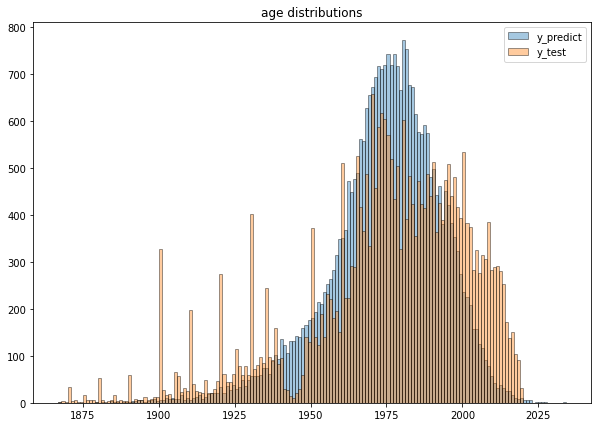

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

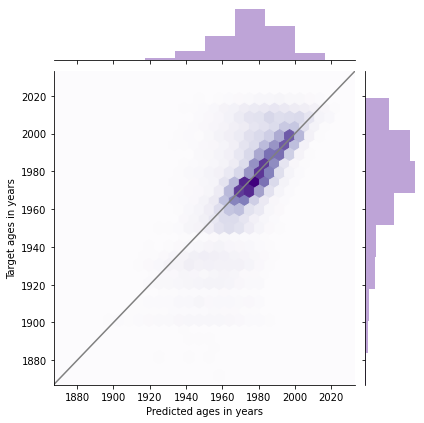

invalid value encountered in true_divide


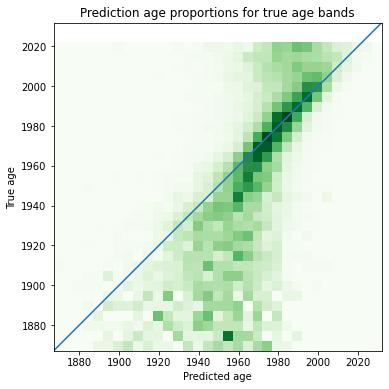

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


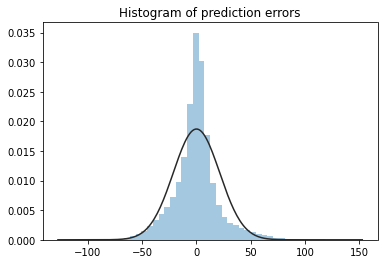

Excess kurtosis of normal distribution (should be 0): [3.56314157]
Skewness of normal distribution (should be 0): [0.61602482]


In [107]:
predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1850]
)
predictor.evaluate_regression()
visualizations.plot_prediction_error_histogram(predictor.y_test, predictor.y_predict)

### Prediction error for different age bands

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


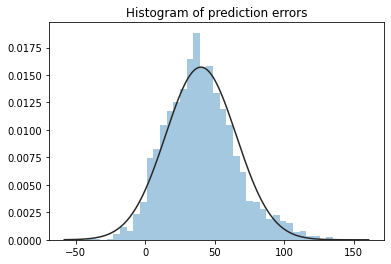

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Excess kurtosis of normal distribution (should be 0): [0.50195985]
Skewness of normal distribution (should be 0): [0.47314934]


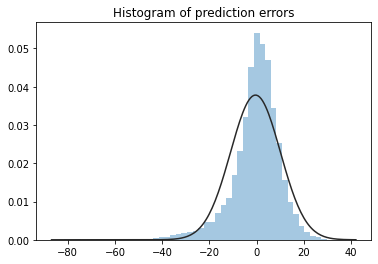

Excess kurtosis of normal distribution (should be 0): [4.8212398]
Skewness of normal distribution (should be 0): [-1.36377136]


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


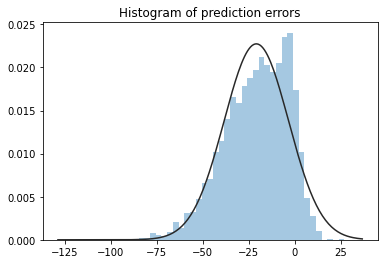

Excess kurtosis of normal distribution (should be 0): [0.40191618]
Skewness of normal distribution (should be 0): [-0.64456782]


In [108]:
old_buildings_test = predictor.y_test[predictor.y_test[dataset.AGE_ATTRIBUTE] < 1930]
old_buildings_predict = predictor.y_predict.iloc[old_buildings_test.index]

medium_buildings_test = predictor.y_test[predictor.y_test[dataset.AGE_ATTRIBUTE].between(1970, 1985)]
medium_buildings_predict = predictor.y_predict.iloc[medium_buildings_test.index]

new_buildings_test = predictor.y_test[predictor.y_test[dataset.AGE_ATTRIBUTE] > 2000]
new_buildings_predict = predictor.y_predict.iloc[new_buildings_test.index]

visualizations.plot_prediction_error_histogram(old_buildings_test, old_buildings_predict)
visualizations.plot_prediction_error_histogram(medium_buildings_test, medium_buildings_predict)
visualizations.plot_prediction_error_histogram(new_buildings_test, new_buildings_predict)

invalid value encountered in true_divide


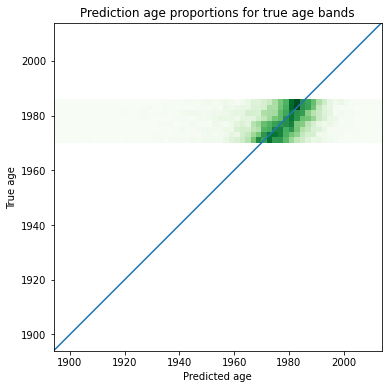

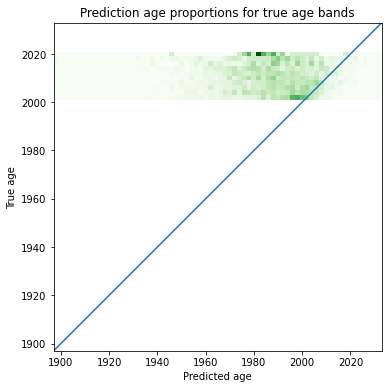

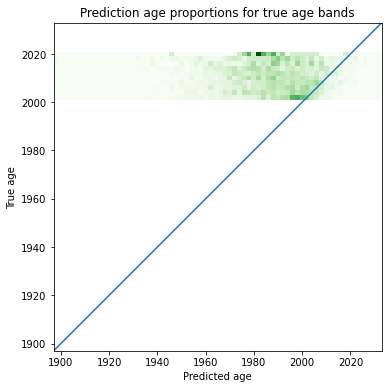

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


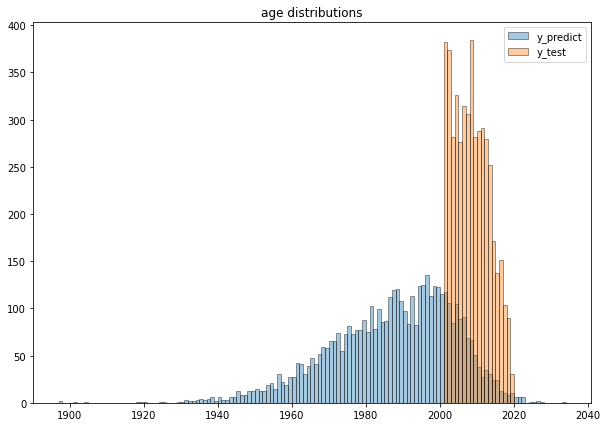

In [117]:
visualizations.plot_relative_grid(old_buildings_test, old_buildings_predict, bin_size=2)
visualizations.plot_relative_grid(medium_buildings_test, medium_buildings_predict, bin_size=2)
visualizations.plot_relative_grid(new_buildings_test, new_buildings_predict, bin_size=2)
visualizations.plot_histogram(
            new_buildings_test, new_buildings_predict, bins=utils.age_bins(new_buildings_predict))

2022-01-18 19:13:45,468 | INFO : Dataset length: 1475359
2022-01-18 19:13:48,298 | INFO : Test dataset length: 295072
2022-01-18 19:13:48,299 | INFO : Training dataset length: 1180287
2022-01-18 19:13:48,301 | INFO : Standard deviation of test set: 32.875023943105106
2022-01-18 19:13:48,834 | INFO : Test dataset length after preprocessing: 53491
2022-01-18 19:13:48,835 | INFO : Training dataset length after preprocessing: 213524
2022-01-18 19:13:48,836 | INFO : Standard deviation of test set after preprocessing: 5.150159951105395


MAE: 2.618497423011289 y
RMSE: 3.5432115657957177 y
R2: 0.5266734625808579


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


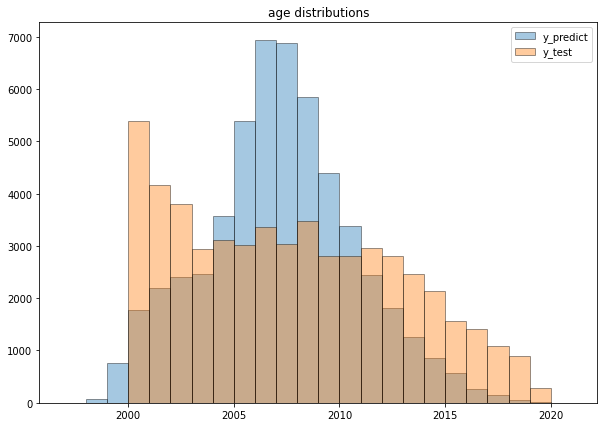

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

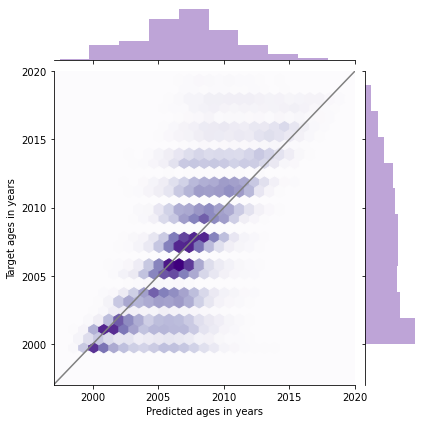

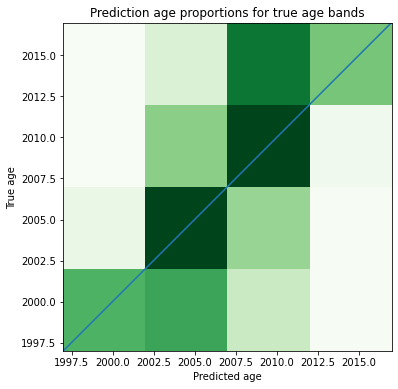

In [114]:
predictor_post_2000 = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_2000]
)
predictor_post_2000.evaluate_regression()

invalid value encountered in true_divide


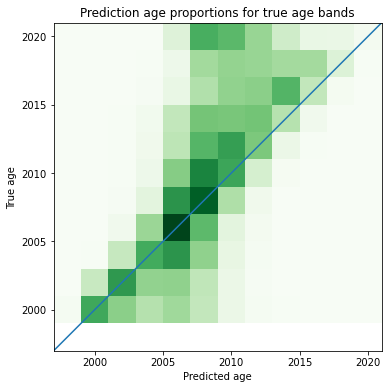

In [116]:
visualizations.plot_relative_grid(predictor_post_2000.y_test, predictor_post_2000.y_predict, bin_size=2)


2022-01-18 19:35:02,502 | INFO : Dataset length: 20000
2022-01-18 19:35:02,521 | INFO : Test dataset length: 4000
2022-01-18 19:35:02,522 | INFO : Training dataset length: 16000
2022-01-18 19:35:02,523 | INFO : Standard deviation of test set: 3.9363382257063084
2022-01-18 19:35:02,532 | INFO : Test dataset length after preprocessing: 4000
2022-01-18 19:35:02,533 | INFO : Training dataset length after preprocessing: 16000
2022-01-18 19:35:02,534 | INFO : Standard deviation of test set after preprocessing: 3.9363382257063084


MAE: 2.384511291503906 y
RMSE: 3.122717673553198 y
R2: 0.3705094506824719


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


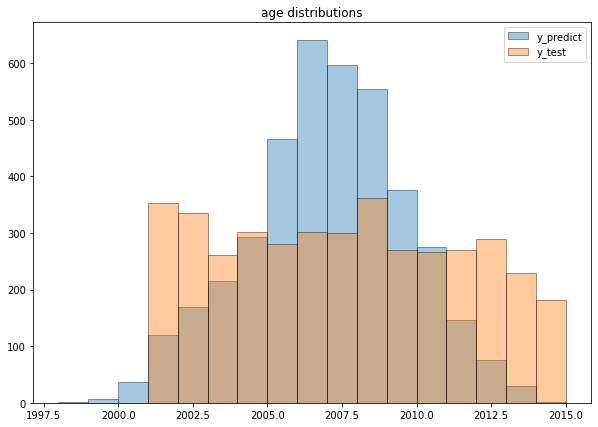

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

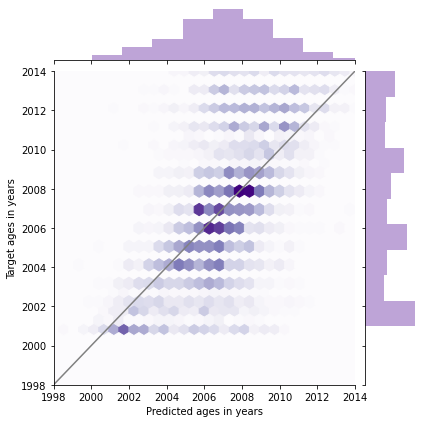

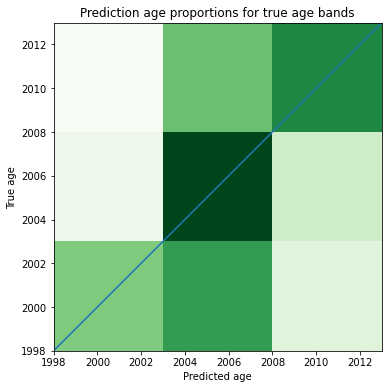

In [121]:
df = data_netherlands_sample.copy()
df = df[df[dataset.AGE_ATTRIBUTE] > 2000]
df = df[df[dataset.AGE_ATTRIBUTE] < 2015]
df = df[:20000]
predictor_2000_2015 = AgePredictor(
    model=XGBRegressor(),
    df=df,
    test_training_split=split_80_20,
    preprocessing_stages=[]
)
predictor_2000_2015.evaluate_regression()

2022-01-18 19:35:40,731 | INFO : Dataset length: 20000
2022-01-18 19:35:40,744 | INFO : Test dataset length: 4000
2022-01-18 19:35:40,744 | INFO : Training dataset length: 16000
2022-01-18 19:35:40,745 | INFO : Standard deviation of test set: 3.9777396899194013
2022-01-18 19:35:40,753 | INFO : Test dataset length after preprocessing: 4000
2022-01-18 19:35:40,754 | INFO : Training dataset length after preprocessing: 16000
2022-01-18 19:35:40,755 | INFO : Standard deviation of test set after preprocessing: 3.9777396899194013


MAE: 1.984285369873047 y
RMSE: 2.6557056538484773 y
R2: 0.5541428392908196


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


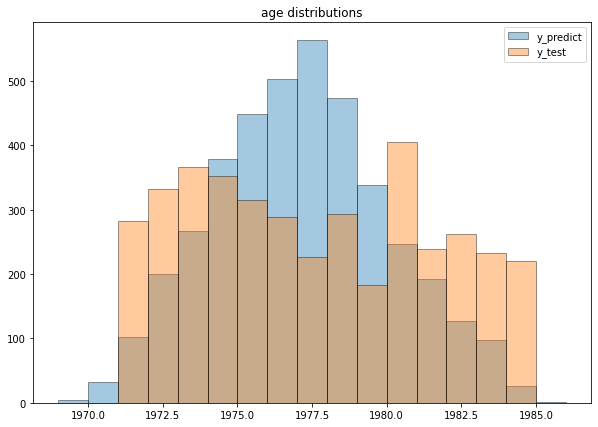

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

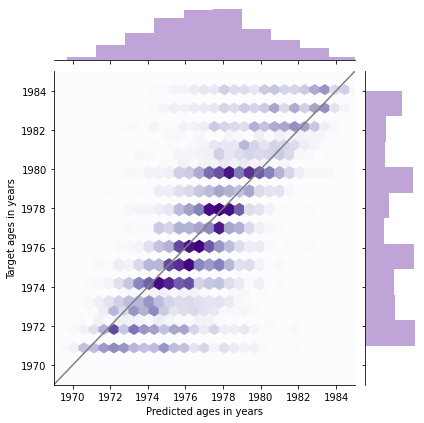

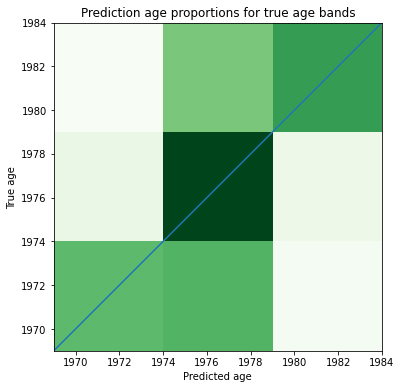

In [122]:
df = data_netherlands_sample.copy()
df = df[df[dataset.AGE_ATTRIBUTE] > 1970]
df = df[df[dataset.AGE_ATTRIBUTE] < 1985]
df = df[:20000]
predictor_1970_1985 = AgePredictor(
    model=XGBRegressor(),
    df=df,
    test_training_split=split_80_20,
    preprocessing_stages=[]
)
predictor_1970_1985.evaluate_regression()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


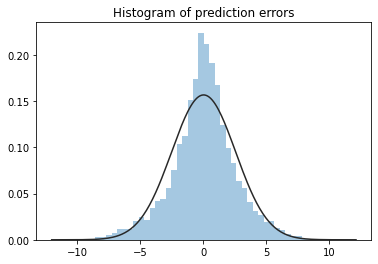

Excess kurtosis of normal distribution (should be 0): [1.13228471]
Skewness of normal distribution (should be 0): [-0.20405381]


In [110]:
visualizations.plot_prediction_error_histogram(predictor_1970_1985.y_test, predictor_1970_1985.y_predict)


2022-01-18 19:36:15,959 | INFO : Dataset length: 20000
2022-01-18 19:36:15,976 | INFO : Test dataset length: 4000
2022-01-18 19:36:15,976 | INFO : Training dataset length: 16000
2022-01-18 19:36:15,977 | INFO : Standard deviation of test set: 3.27367937979126
2022-01-18 19:36:15,987 | INFO : Test dataset length after preprocessing: 4000
2022-01-18 19:36:15,987 | INFO : Training dataset length after preprocessing: 16000
2022-01-18 19:36:15,988 | INFO : Standard deviation of test set after preprocessing: 3.27367937979126


MAE: 2.051226043701172 y
RMSE: 2.7452291657472943 y
R2: 0.29661434019064814


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


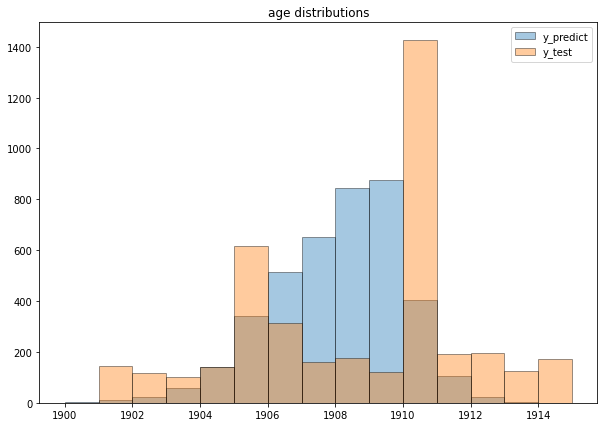

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

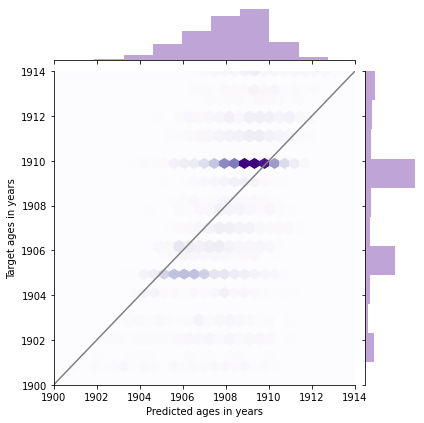

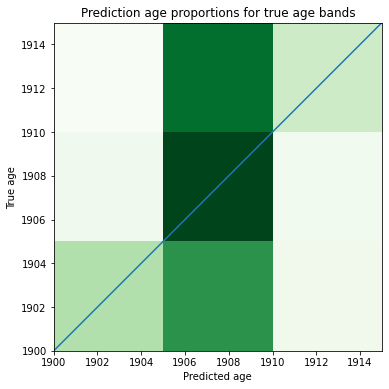

In [123]:
df = data_netherlands.copy()
df = df[df[dataset.AGE_ATTRIBUTE] > 1900]
df = df[df[dataset.AGE_ATTRIBUTE] < 1915]
df = df[:20000]
predictor_1900_1915 = AgePredictor(
    model=XGBRegressor(),
    df=df,
    test_training_split=split_80_20,
    preprocessing_stages=[]
)
predictor_1900_1915.evaluate_regression()

## Are medium-aged buildings just predicted well because they represent test set mean? In short: No, even if they don't represent mean, they are predicted well

2022-01-24 11:55:01,718 | INFO : Dataset length: 1475359
2022-01-24 11:55:04,496 | INFO : Test dataset length: 295072
2022-01-24 11:55:04,497 | INFO : Training dataset length: 1180287
2022-01-24 11:55:04,499 | INFO : Standard deviation of test set: 32.875023943105106
2022-01-24 11:55:04,501 | INFO : Mean age of test set: 1973.3624132415139
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


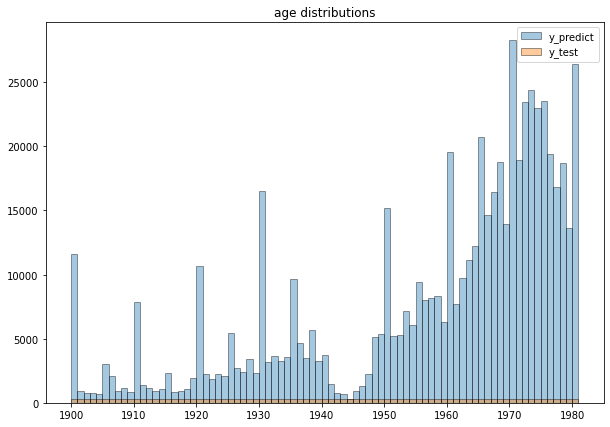

2022-01-24 11:55:15,087 | INFO : Downsampling distribution results in: [(1900, 325), (1901, 325), (1902, 325), (1903, 325), (1904, 325), (1905, 325), (1906, 325), (1907, 325), (1908, 325), (1909, 325), (1910, 325), (1911, 325), (1912, 325), (1913, 325), (1914, 325), (1915, 325), (1916, 325), (1917, 325), (1918, 325), (1919, 325), (1920, 325), (1921, 325), (1922, 325), (1923, 325), (1924, 325), (1925, 325), (1926, 325), (1927, 325), (1928, 325), (1929, 325), (1930, 325), (1931, 325), (1932, 325), (1933, 325), (1934, 325), (1935, 325), (1936, 325), (1937, 325), (1938, 325), (1939, 325), (1940, 325), (1941, 325), (1942, 325), (1943, 325), (1944, 325), (1945, 325), (1946, 325), (1947, 325), (1948, 325), (1949, 325), (1950, 325), (1951, 325), (1952, 325), (1953, 325), (1954, 325), (1955, 325), (1956, 325), (1957, 325), (1958, 325), (1959, 325), (1960, 325), (1961, 325), (1962, 325), (1963, 325), (1964, 325), (1965, 325), (1966, 325), (1967, 325), (1968, 325), (1969, 325), (1970, 325), (1971

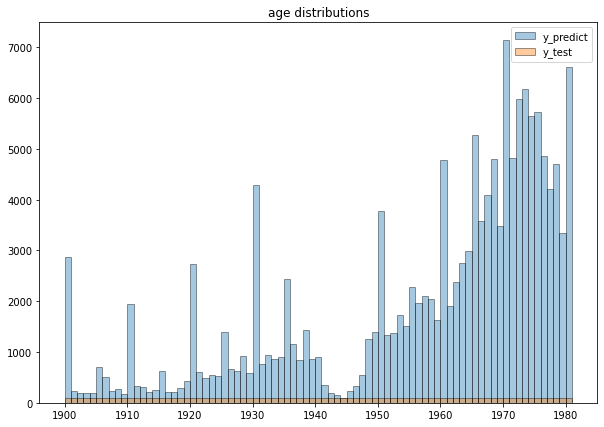

2022-01-24 11:55:17,262 | INFO : Downsampling distribution results in: [(1900, 87), (1901, 87), (1902, 87), (1903, 87), (1904, 87), (1905, 87), (1906, 87), (1907, 87), (1908, 87), (1909, 87), (1910, 87), (1911, 87), (1912, 87), (1913, 87), (1914, 87), (1915, 87), (1916, 87), (1917, 87), (1918, 87), (1919, 87), (1920, 87), (1921, 87), (1922, 87), (1923, 87), (1924, 87), (1925, 87), (1926, 87), (1927, 87), (1928, 87), (1929, 87), (1930, 87), (1931, 87), (1932, 87), (1933, 87), (1934, 87), (1935, 87), (1936, 87), (1937, 87), (1938, 87), (1939, 87), (1940, 87), (1941, 87), (1942, 87), (1943, 87), (1944, 87), (1945, 87), (1946, 87), (1947, 87), (1948, 87), (1949, 87), (1950, 87), (1951, 87), (1952, 87), (1953, 87), (1954, 87), (1955, 87), (1956, 87), (1957, 87), (1958, 87), (1959, 87), (1960, 87), (1961, 87), (1962, 87), (1963, 87), (1964, 87), (1965, 87), (1966, 87), (1967, 87), (1968, 87), (1969, 87), (1970, 87), (1971, 87), (1972, 87), (1973, 87), (1974, 87), (1975, 87), (1976, 87), (197

MAE: 12.011759821194968 y
RMSE: 16.085355379996425 y
R2: 0.526697577376622


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


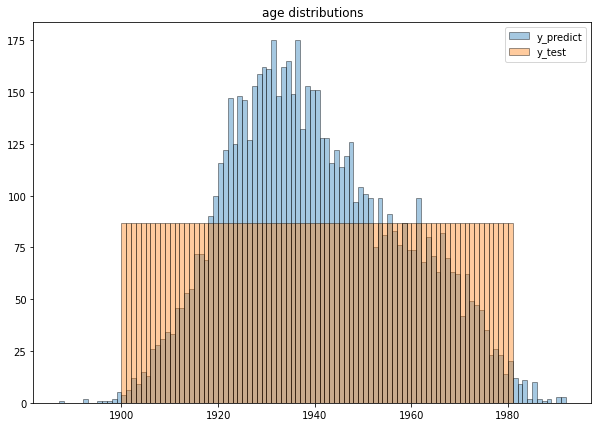

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

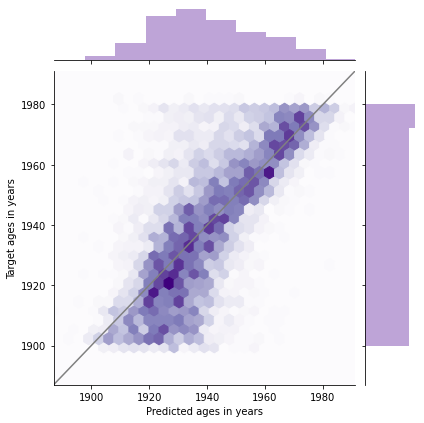

invalid value encountered in true_divide


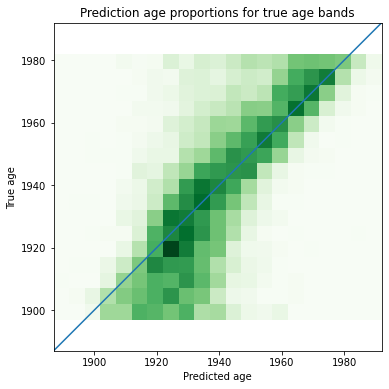

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


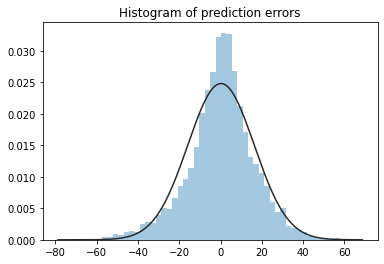

Excess kurtosis of normal distribution (should be 0): [1.07002728]
Skewness of normal distribution (should be 0): [-0.30103131]


In [16]:
predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900, remove_buildings_post_1980, undersample_skewed_distribution]
)
predictor.evaluate_regression()
visualizations.plot_prediction_error_histogram(predictor.y_test, predictor.y_predict)

In [9]:
data_netherlands_sample['age'].mean()

1973.4373441058453